# Módulo de estatística 

## Projeto - Previsão do faturamento da empresa de acordo com os produtos

## Partipante: Leonardo do Ó

### Instruções

- O projeto deverá ser entregue até dia 22/11 antes do início da aula
- O projeto poderá ser feito em grupo com até 4 integrantes
- Serão 2 projetos A e B porém apenas 1 projeto deverá ser entregue e escolhido pelo grupo

- A entrega deve ser feita em jupyter notebook com os códigos explícitos e comentados. Além disso os conceitos, decisões e conclusões usadas devem estar destacadas no notebook
- A entrega pode ser feita pelo class ou no repositório do git de algum dos alunos

### Informações sobre o projeto

Dataset (conjunto de dados a ser utilizado) é um arquivo txt separado por tabulação e encontrasse no github:

https://github.com/renatapink/DSdegree/tree/master/Modulo4/Projeto

Link dos dados: <br>
https://raw.githubusercontent.com/renatapink/DSdegree/master/Modulo4/Projeto/sim_ts.txt

#### Case

Imagine que você trabalha numa empresa de benefícios que vende diversos produtos para os RHs clientes, com o intuito de melhorar a qualidade de vida de seus colaboradores por meio de alimentação saudável, transporte, saúde, entre outros.

Para ajudar no direcionamento e estratégia corporativa, bem como definir a meta do time comercial, você ficou encarregado de prever qual seria o faturamento mensal esperado para 2022. 

Utilizando as metodologias vistas em aula, sobretudo ligadas a séries temporais, faça o seguinte:

#### Etapa I

**EDA - Análise exploratória de dados**

- Análise de medidas de posição, dispersão, correlação (análises univaridas e bivariadas) - histograma, boxplot, mapa de calor, etc...
- Identificação e tratamento de outliers e missings (valores faltantes), caso necessário (sempre explicando a opção)

#### Etapa II
a. Ajuste um modelo para o faturamento total (sem quebrar por produto) e realize a projeção para os meses faltantes até o final de 2022.

b. Faça ajustes indivíduais para cada produto e consolide os resultados para obter o faturamento total para os meses faltantes até o final de 2022.

c. Qual dos dois cenários obteve a melhor projeção? Qual cenário você usaria dentro da sua empresa pensando nos desdobramentos estratégicos citados acima? Justifique a sua resposta com base em métricas bem definidas e no entendimento do problema.

#### Informação sobre os atributos

- **vlr:** Vlr. faturado no mês
- **date:** Mês de referência do faturamento
- **produto:** Produto ao qual o faturamento diz respeito

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore") # ignorando os warnings

%matplotlib inline 

### Organizando os dados

Na célula abaixo:

   - Transformamos o valor cientifico de faturamento em float
   - Utilizamos o datetime para criamos e separamos os dados por mês e ano
   - Renomeamos as colunas para melhorar a visualização

In [2]:
df = pd.read_csv('sim_ts.txt', sep = '\t')

pd.set_option('display.float_format', lambda x: '%.2f' % x) # Transformamos o valor cientifico em float
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d' ) # Transformamos a coluna de objeto para data
df['Ano'] = df['date'].dt.year # Extraimos o ano do datetime e criei a coluna ano
df['Mês'] = df['date'].dt.month # Extraimos o mês do datetime e criei a coluna Mês
df['Nome do Mês'] = df['date'].dt.month_name() # Criamos a coluna com o nome dos meses
df = df.rename(columns= {'date': 'Data', 'vlr':'Faturamento', 'produto': 'Produto'}) # Renomeamos as colunas para melhor vizualização
faturamento = df['Faturamento'] # Criamos uma variavel apenas com o faturamento com o intuito de melhorar a vizualização dos dados
df = df.drop(columns=['Faturamento']) # Excluímos a coluna faturamento para deixar no intuito de deixa-la como ultima coluna
df['Faturamento'] = faturamento
df = df.set_index('Data')

df

,Produto,Ano,Mês,Nome do Mês,Faturamento
Data,,,,,
2009-12-01,alimenticio,2009,12,December,1006194647.35
2010-01-01,alimenticio,2010,1,January,998697976.12
2010-02-01,alimenticio,2010,2,February,999418206.44
2010-03-01,alimenticio,2010,3,March,990000000.00
2010-04-01,alimenticio,2010,4,April,994207536.01
...,...,...,...,...,...
2021-06-01,saude,2021,6,June,25303903.29
2021-07-01,saude,2021,7,July,26655172.10
2021-08-01,saude,2021,8,August,26237136.95


### Medidas de posicionamento e dispersão

Nas células abaixo separamos cada produto em uma coluna exclusiva, em seguida demos o describe para termos todas as medidas de posição e dispersão.

### Tratamento de dados faltantes

Completamos as datas faltantes das séries temporais e atribuimos um valor 0, pois percebemos que ao não ocorrer uma venda de determinado produto naqueles o mês era pulado e ao unificarmos os produtos por coluna, os dados faltantes apareceram.

### Tratamento de outliers

Não houve necessidade de tratamento de outliers, pois neste dataframe entendemos que os valores cresceram gradativamente com o tempo e entrada de novos produtos.

In [3]:
# Criando um DF para organizar em anos e produtos
a = df[df['Produto']=='alimenticio'].groupby('Data')['Faturamento'].sum()
b = df[df['Produto']=='transporte'].groupby('Data')['Faturamento'].sum()
c = df[df['Produto']=='auxilio_final_de_ano'].groupby('Data')['Faturamento'].sum()
d = df[df['Produto']=='bonificacao'].groupby('Data')['Faturamento'].sum()
e = df[df['Produto']=='saude'].groupby('Data')['Faturamento'].sum()# Criando um DF por concatenação
df_aux2 = pd.concat([a,b,c,d,e], axis=1)
df_aux2.columns=df['Produto'].unique()

In [4]:
df_aux2

,alimenticio,transporte,auxilio_final_de_ano,bonificacao,saude
Data,,,,,
2009-12-01,1006194647.35,NaN,666666.67,NaN,NaN
2010-01-01,998697976.12,NaN,654429.22,NaN,NaN
2010-02-01,999418206.44,NaN,622883.27,NaN,NaN
2010-03-01,990000000.00,NaN,580597.41,NaN,NaN
2010-04-01,994207536.01,NaN,539057.42,NaN,NaN
...,...,...,...,...,...
2021-06-01,1887380942.18,173539516.30,NaN,NaN,25303903.29
2021-07-01,1872678449.90,173704587.26,NaN,195188.51,26655172.10
2021-08-01,1899408288.46,175944687.88,NaN,NaN,26237136.95


In [5]:
df_aux2 = df_aux2.fillna(0)
df_aux2['faturamento'] = df_aux2['alimenticio'] + df_aux2['transporte'] + df_aux2['auxilio_final_de_ano'] + df_aux2['bonificacao'] + df_aux2['saude']

In [6]:
df_aux2.describe()

,alimenticio,transporte,auxilio_final_de_ano,bonificacao,saude,faturamento
count,143.00,143.00,143.00,143.00,143.00,143.00
mean,1387476175.08,99172350.98,1021311.62,90078.66,8765713.89,1496525630.24
std,296544618.24,86431964.57,550565.48,74894.59,11006606.35,383627165.67
min,990000000.00,0.00,0.00,0.00,0.00,990580597.41
25%,1122228252.79,0.00,606826.70,0.00,0.00,1122927990.72
50%,1364440574.57,157637574.37,880817.56,117604.82,0.00,1527953147.35
75%,1644394278.42,173864237.56,1358136.90,151067.89,21207270.22,1861295271.65
max,1990000000.00,200000000.00,2500000.00,201331.27,28000000.00,2193339863.39


### Criando os gráficos do faturamento de cada produto e do total separadamente

<AxesSubplot:title={'center':'Faturamento alimenticio'}, xlabel='Data'>

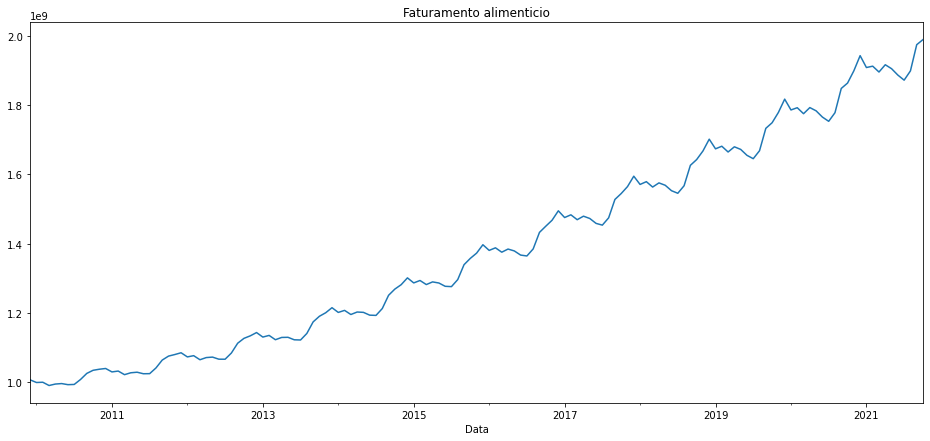

In [7]:
plt.figure(figsize=(16,7))
plt.title('Faturamento alimenticio')
df_aux2['alimenticio'].plot()

<AxesSubplot:title={'center':'Faturamento transporte'}, xlabel='Data'>

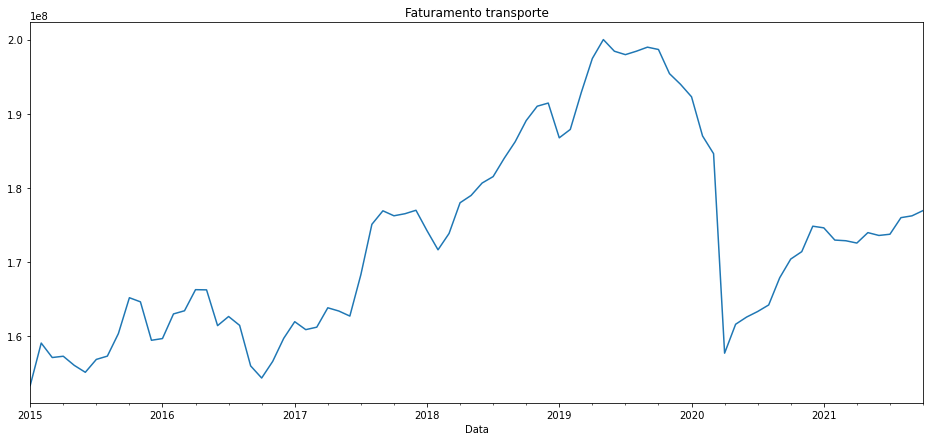

In [8]:
plt.figure(figsize=(16,7))
plt.title('Faturamento transporte')
df_trans = df_aux2['transporte']
df_trans = df_trans['2015':]
df_trans.plot()

<AxesSubplot:title={'center':'Faturamento auxilio final de ano'}, xlabel='Data'>

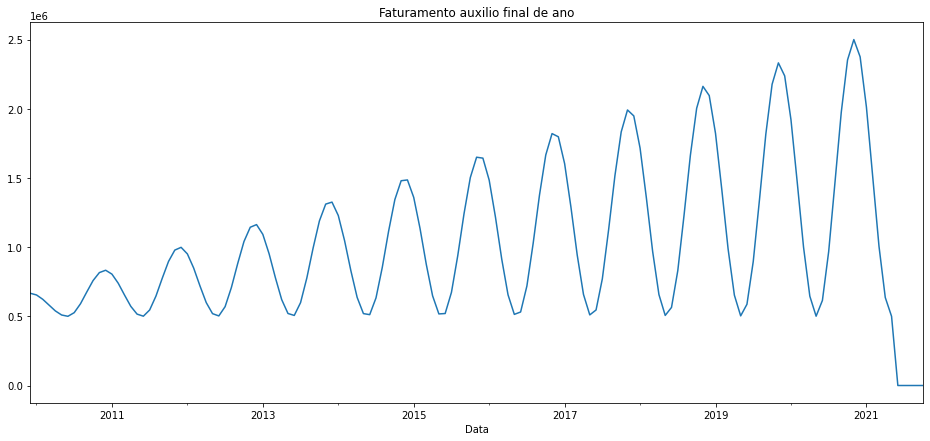

In [9]:
plt.figure(figsize=(16,7))
plt.title('Faturamento auxilio final de ano')
df_aux = df_aux2['auxilio_final_de_ano']
df_aux.plot()

<AxesSubplot:title={'center':'Faturamento bonificação'}, xlabel='Data'>

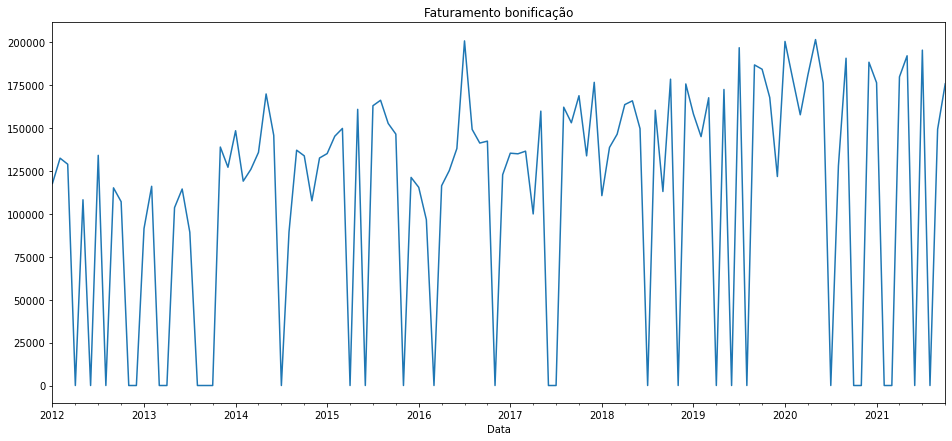

In [10]:
plt.figure(figsize=(16,7))
plt.title('Faturamento bonificação')
df_bon = df_aux2['bonificacao']
df_bon = df_bon['2012':]
df_bon.plot()

<AxesSubplot:title={'center':'Faturamento saúde'}, xlabel='Data'>

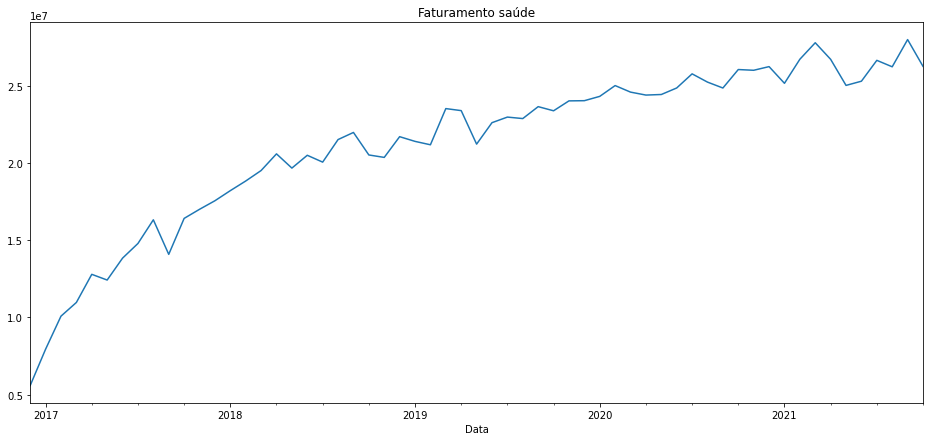

In [11]:
plt.figure(figsize=(16,7))
plt.title('Faturamento saúde')
df_sau = df_aux2['saude']
df_sau = df_sau['2016-12-01':]
df_sau.plot()

<AxesSubplot:title={'center':'Faturamento Total'}, xlabel='Data'>

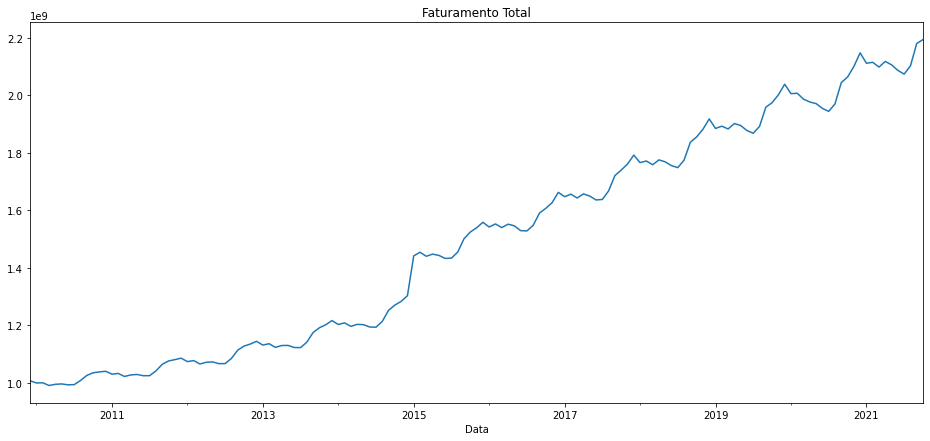

In [12]:
plt.figure(figsize=(16,7))
plt.title('Faturamento Total')
df_fat = df_aux2['faturamento']
df_fat.plot()

### A. Ajuste um modelo para o faturamento total (sem quebrar por produto) e realize a projeção para os meses faltantes até o final de 2022.

- Escolhemos o modelo **SARIMA** por entendermos que era o mais adequado, pois o modelo inclui um parametro de sazonalidade necessário nas séries temporais. 

- Automatizamos a identificação do **best model** para definição dos parâmetros, transformando em um dataframe e ordenamos para não precisarmos procurar pelos melhores parâmetros (ordem, sazonalidade). 

In [13]:
import itertools

# Define os parametros p, d e q como valores entre 0 e 2
p = d = q = range(0, 2)

# Gera as diferentes combinações
pdq = list(itertools.product(p, d, q))

# Gera as combinações para a sazonalidade (12 significa uma sazonalidade mensal)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Exemplos de Combinações para o SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Exemplos de Combinações para o SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
data = pd.DataFrame(columns=['order', 'seasonal_order', 'aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_fat,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            data = data.append(pd.DataFrame({'order': [param], 'seasonal_order': [param_seasonal], 'aic': results.aic}))
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue
data.sort_values('aic')

,order,seasonal_order,aic
0,"(0, 1, 1)","(1, 1, 1, 12)",4217.54
0,"(1, 1, 1)","(1, 1, 1, 12)",4219.53
0,"(0, 1, 1)","(0, 1, 1, 12)",4226.34
0,"(1, 1, 1)","(0, 1, 1, 12)",4228.33
0,"(0, 1, 0)","(1, 1, 1, 12)",4250.25
...,...,...,...
0,"(0, 0, 1)","(0, 0, 1, 12)",5715.56
0,"(0, 0, 1)","(1, 0, 0, 12)",5792.39
0,"(0, 0, 0)","(0, 0, 1, 12)",5801.83
0,"(0, 0, 0)","(0, 0, 0, 12)",6414.43


In [15]:
# Vamos agora ajustar o modelo SARIMA com os parâmetros acima (dar fit no modelo):

mod = sm.tsa.statespace.SARIMAX(df_fat,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # modelo treinado

In [16]:
# Calcula as predições a partir de 2021-10-01

pred = results.get_prediction(start=pd.to_datetime('2009-12-01'), dynamic=False) # valor previsto
pred_ci = pred.conf_int()

In [17]:
pred #valor previsto

In [18]:
pred_ci # valor previsto com intervalo de confiança

,lower faturamento,upper faturamento
Data,,
2009-12-01,-3394.76,3394.76
2010-01-01,967479088.42,1046243539.62
2010-02-01,959610695.11,1038375146.31
2010-03-01,960709044.58,1039473495.79
2010-04-01,950743053.89,1029507505.09
...,...,...
2021-06-01,2048941845.62,2127706296.63
2021-07-01,2036942938.25,2115707389.26
2021-08-01,2058544605.42,2137309056.43


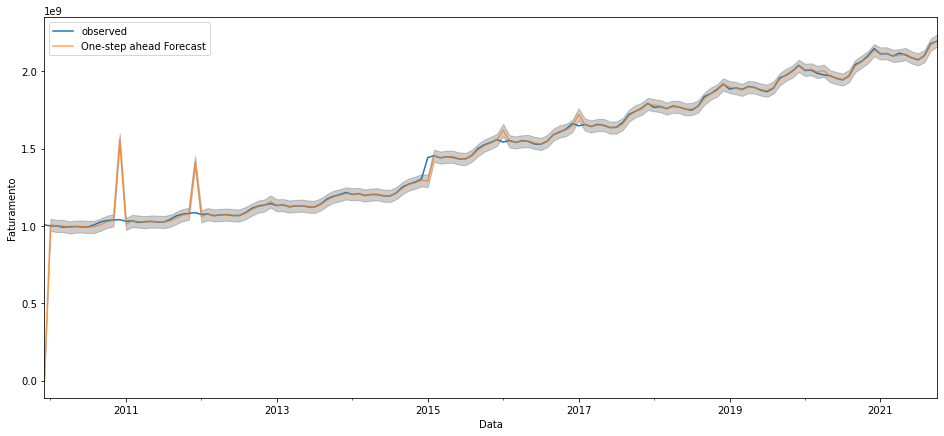

In [19]:
# Plot com o Forecasting

plt.figure(figsize=(16,7))

ax = df_fat.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')
plt.legend()

plt.show()

In [20]:
# Vamos fazer 14 predições futuras
pred_uc = results.get_forecast(steps=14)

# Define o intervalo de confiança para o Forecasting
pred_ci = pred_uc.conf_int()

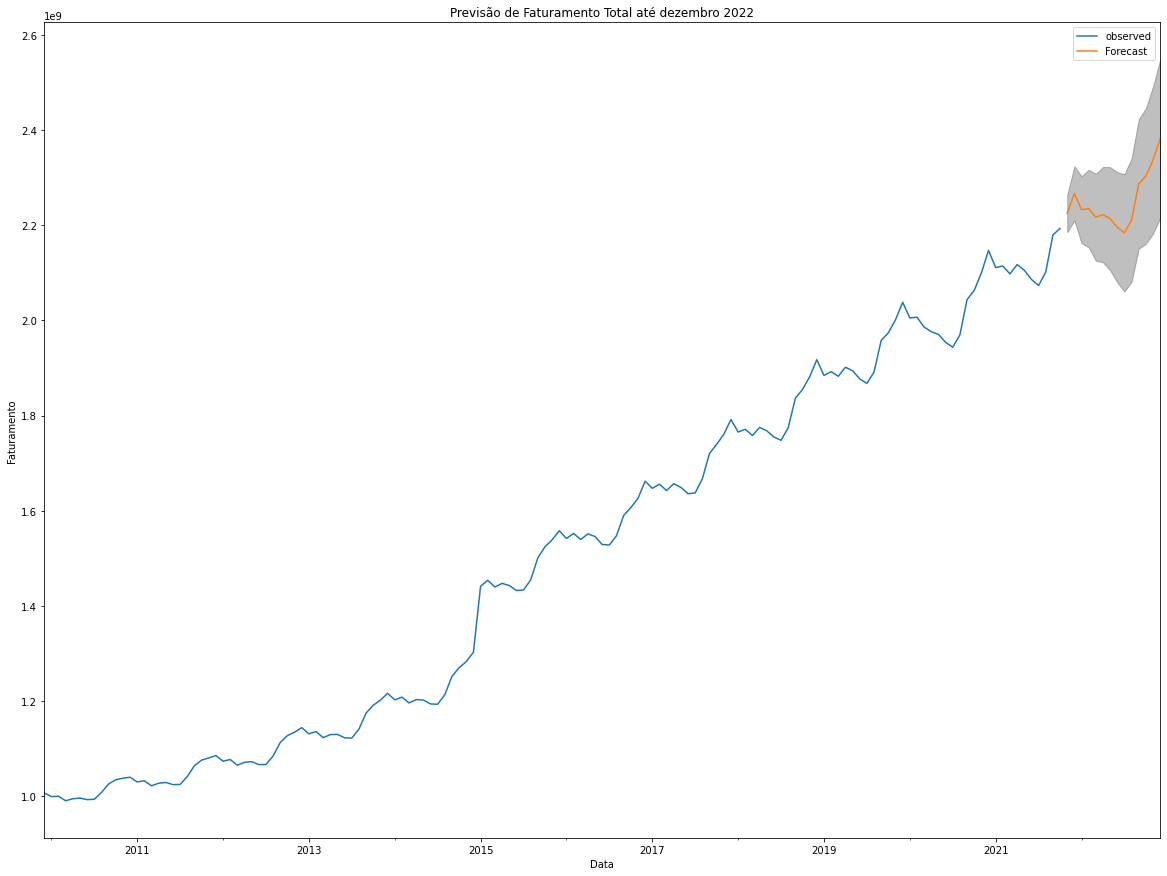

In [21]:
ax = df_fat.plot(label='observed', figsize=(20, 15))
plt.title('Previsão de Faturamento Total até dezembro 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')

plt.legend()
plt.show()

In [22]:
faturamento_total = pred_ci

## B. Faça ajustes indivíduais para cada produto e consolide os resultados para obter o faturamento total para os meses faltantes até o final de 2022.

### Alimenticio total


In [23]:
data = pd.DataFrame(columns=['order', 'seasonal_order', 'aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_aux2['alimenticio'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            data = data.append(pd.DataFrame({'order': [param], 'seasonal_order': [param_seasonal], 'aic': results.aic}))
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue
data.sort_values('aic')

,order,seasonal_order,aic
0,"(0, 1, 0)","(1, 1, 0, 12)",3500.19
0,"(0, 1, 0)","(1, 1, 1, 12)",3639.68
0,"(0, 1, 1)","(1, 1, 1, 12)",3665.02
0,"(1, 1, 1)","(1, 1, 1, 12)",3666.41
0,"(1, 1, 0)","(1, 1, 0, 12)",3681.67
...,...,...,...
0,"(0, 0, 0)","(0, 0, 0, 12)",6390.19
0,"(1, 0, 1)","(0, 0, 1, 12)",725753225.40
0,"(1, 0, 0)","(0, 0, 1, 12)",725791320.78
0,"(0, 0, 0)","(0, 0, 1, 12)",12693071322039.73


In [24]:
# Vamos agora ajustar o modelo SARIMA com os parâmetros acima (dar fit no modelo):

mod = sm.tsa.statespace.SARIMAX(df_aux2['alimenticio'],
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # modelo treinado

In [25]:
# Calcula as predições a partir de 2021-10-01

pred = results.get_prediction(start=pd.to_datetime('2009-12-01'), dynamic=False) # valor previsto
pred_ci = pred.conf_int()


In [26]:
pred #valor previsto

In [27]:
pred_ci # valor previsto com intervalo de confiança

,lower alimenticio,upper alimenticio
Data,,
2009-12-01,-3394.76,3394.76
2010-01-01,1004906963.74,1007482330.96
2010-02-01,997410292.51,999985659.73
2010-03-01,998130522.83,1000705890.05
2010-04-01,988712316.39,991287683.61
...,...,...
2021-06-01,1885629752.46,1888205113.71
2021-07-01,1871222436.34,1873797797.60
2021-08-01,1898121771.33,1900697132.58


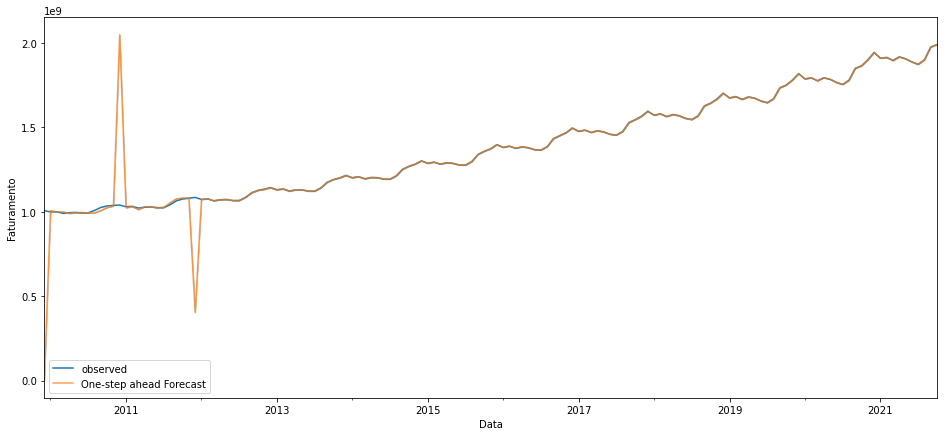

In [28]:
# Plot com o Forecasting

plt.figure(figsize=(16,7))

ax = df_aux2['alimenticio'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')
plt.legend()

plt.show()

In [29]:
# Vamos fazer 14 predições futuras
pred_uc = results.get_forecast(steps=14)

# Define o intervalo de confiança para o Forecasting
pred_ci = pred_uc.conf_int()

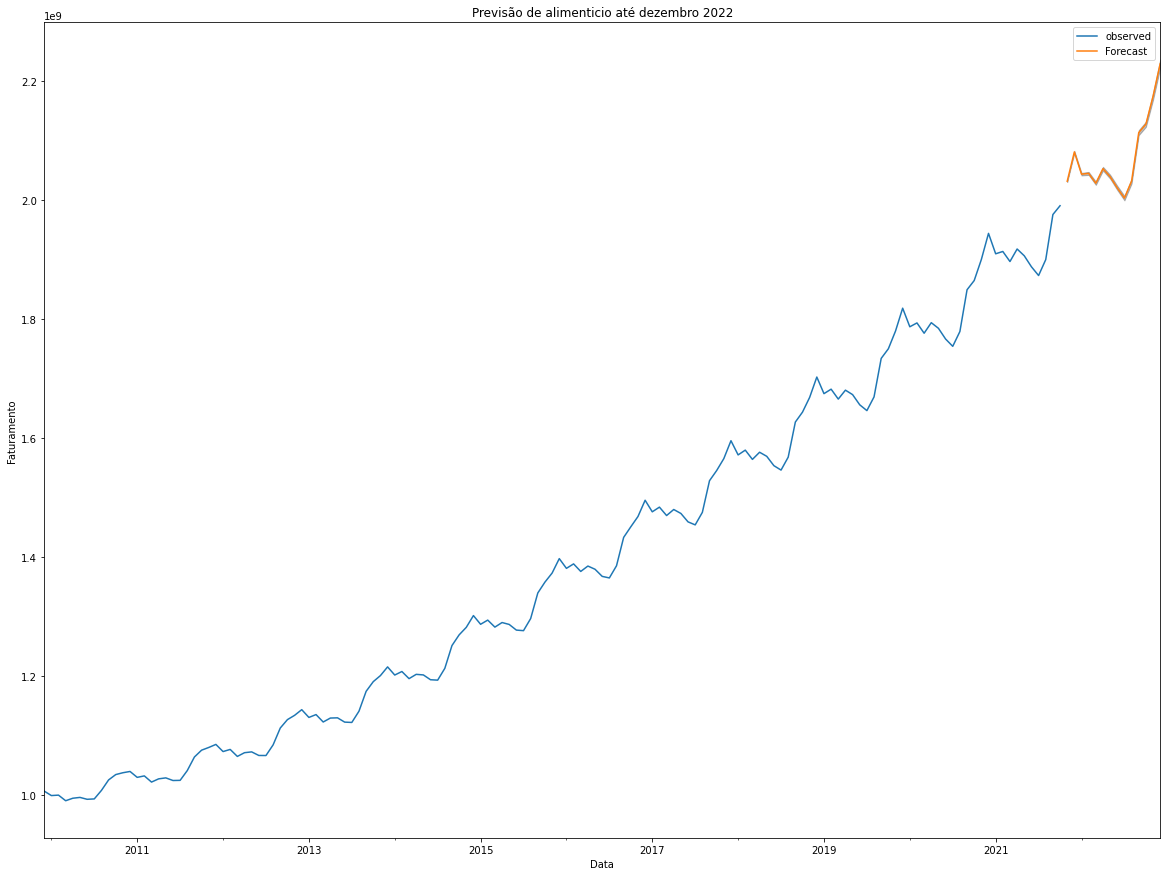

In [30]:
ax = df_aux2['alimenticio'].plot(label='observed', figsize=(20, 15))
plt.title('Previsão de alimenticio até dezembro 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')

plt.legend()
plt.show()

In [31]:
alimenticio = pred_ci

### Transporte

In [32]:
data = pd.DataFrame(columns=['order', 'seasonal_order', 'aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_trans,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            data = data.append(pd.DataFrame({'order': [param], 'seasonal_order': [param_seasonal], 'aic': results.aic}))
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue
data.sort_values('aic')

,order,seasonal_order,aic
0,"(0, 1, 1)","(1, 1, 1, 12)",1865.45
0,"(1, 1, 1)","(1, 1, 1, 12)",1867.33
0,"(0, 1, 1)","(0, 1, 1, 12)",1874.55
0,"(1, 1, 1)","(0, 1, 1, 12)",1876.18
0,"(1, 1, 0)","(1, 1, 0, 12)",1895.95
...,...,...,...
0,"(0, 0, 1)","(0, 0, 1, 12)",2718.78
0,"(0, 0, 0)","(0, 0, 1, 12)",2777.71
0,"(0, 0, 1)","(1, 0, 0, 12)",2791.63
0,"(0, 0, 1)","(0, 0, 0, 12)",3209.66


In [33]:
# Vamos agora ajustar o modelo SARIMA com os parâmetros acima (dar fit no modelo):

mod = sm.tsa.statespace.SARIMAX(df_trans,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # modelo treinado

In [34]:
# Calcula as predições a partir de 2015-10-01

pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False) # valor previsto
pred_ci = pred.conf_int()

In [35]:
pred #valor previsto

In [36]:
pred_ci # valor previsto com intervalo de confiança

,lower transporte,upper transporte
Data,,
2015-01-01,-3394.76,3394.76
2015-02-01,141390185.55,165151209.83
2015-03-01,147961292.49,171722316.78
2015-04-01,144760173.55,168521197.85
2015-05-01,145428469.91,169189494.21
...,...,...
2021-06-01,160880528.65,184641552.29
2021-07-01,161670855.08,185431878.72
2021-08-01,162423222.99,186184246.62


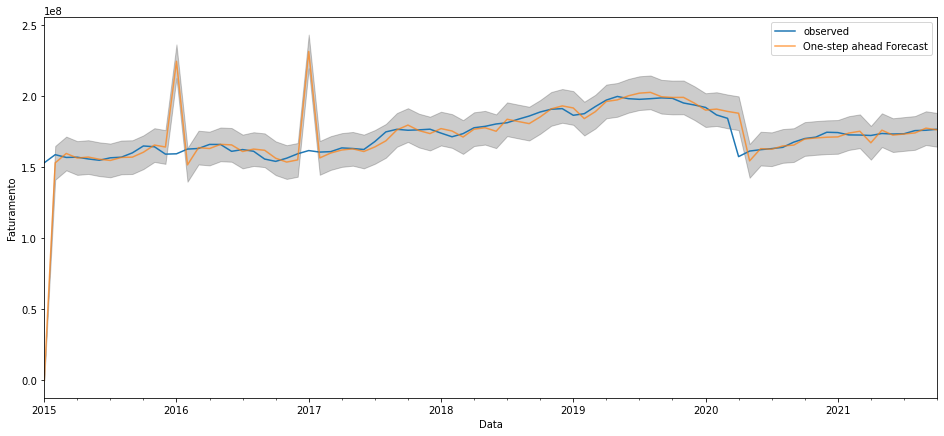

In [37]:
# Plot com o Forecasting

plt.figure(figsize=(16,7))

ax = df_trans.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')
plt.legend()

plt.show()

In [38]:
# Vamos fazer 14 predições futuras
pred_uc = results.get_forecast(steps=14)

# Define o intervalo de confiança para o Forecasting
pred_ci = pred_uc.conf_int()

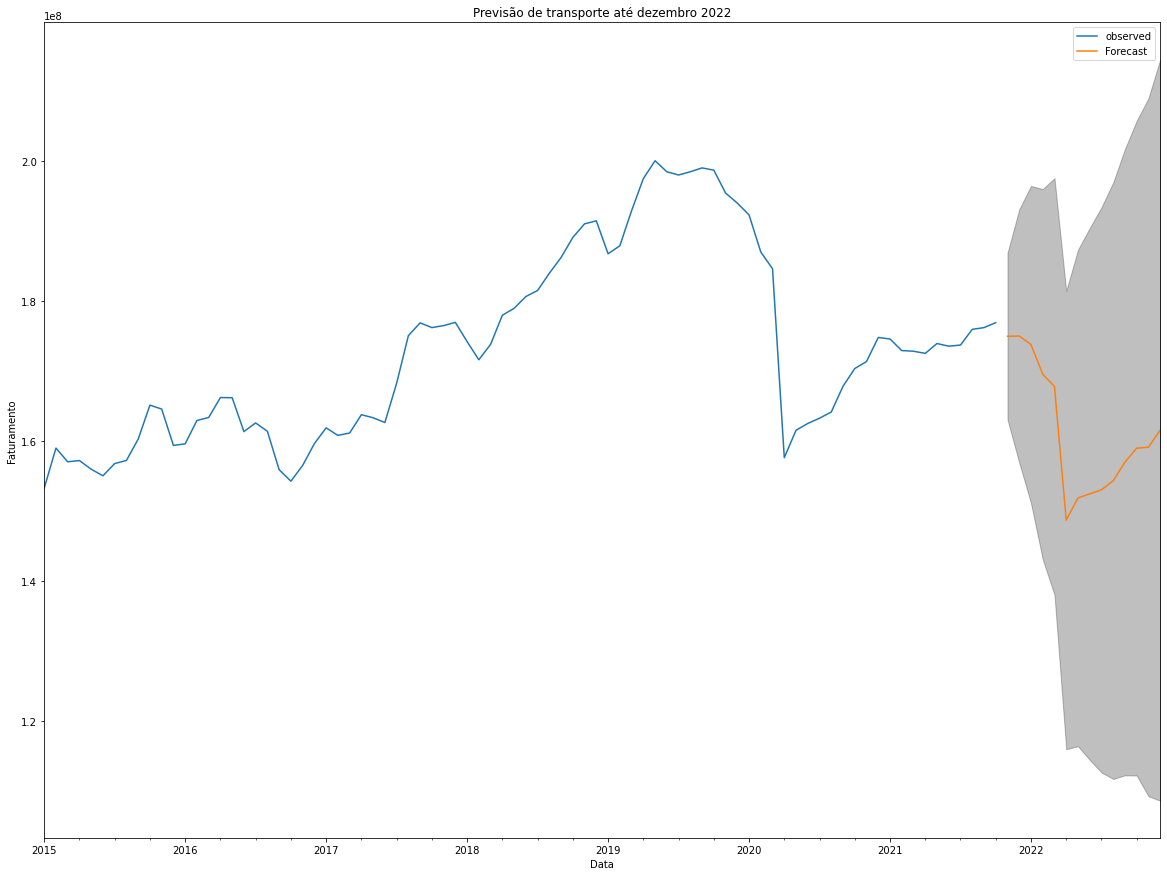

In [39]:
ax = df_trans.plot(label='observed', figsize=(20, 15))
plt.title('Previsão de transporte até dezembro 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')

plt.legend()
plt.show()

In [40]:
transporte = pred_ci

### Auxilio final de ano

In [41]:
data = pd.DataFrame(columns=['order', 'seasonal_order', 'aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_aux,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            data = data.append(pd.DataFrame({'order': [param], 'seasonal_order': [param_seasonal], 'aic': results.aic}))
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue
data.sort_values('aic')

,order,seasonal_order,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",2899.90
0,"(1, 1, 1)","(0, 1, 1, 12)",2900.30
0,"(1, 1, 1)","(1, 1, 0, 12)",2922.74
0,"(1, 1, 0)","(1, 1, 0, 12)",2929.55
0,"(1, 1, 0)","(0, 1, 1, 12)",2930.46
...,...,...,...
0,"(0, 0, 1)","(1, 0, 0, 12)",4223.69
0,"(0, 0, 1)","(0, 0, 0, 12)",4235.20
0,"(0, 0, 0)","(0, 0, 0, 12)",4371.24
0,"(1, 0, 1)","(1, 0, 1, 12)",29684.49


In [42]:
# Vamos agora ajustar o modelo SARIMA com os parâmetros acima (dar fit no modelo):

mod = sm.tsa.statespace.SARIMAX(df_aux,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # modelo treinado

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2009-12-01'), dynamic=False) # valor previsto
pred_ci = pred.conf_int()

In [44]:
pred #valor previsto

In [45]:
pred_ci # valor previsto com intervalo de confiança

,lower auxilio_final_de_ano,upper auxilio_final_de_ano
Data,,
2009-12-01,-3394.76,3394.76
2010-01-01,767294.96,1006768.83
2010-02-01,600182.34,839654.98
2010-03-01,504247.86,743720.37
2010-04-01,433407.92,672880.42
...,...,...
2021-06-01,511692.15,751080.82
2021-07-01,-154596.78,84791.88
2021-08-01,17819.84,257208.51


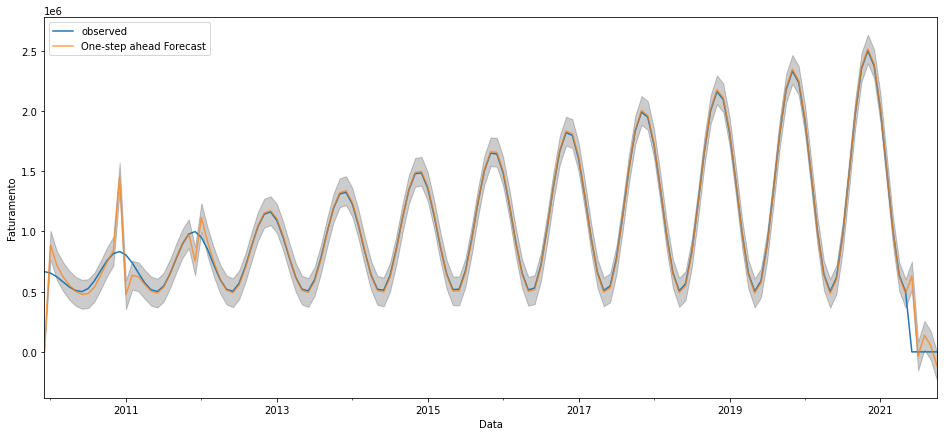

In [46]:
# Plot com o Forecasting

plt.figure(figsize=(16,7))

ax = df_aux.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')
plt.legend()

plt.show()

In [47]:
# Vamos fazer 14 predições futuras
pred_uc = results.get_forecast(steps=14)

# Define o intervalo de confiança para o Forecasting
pred_ci = pred_uc.conf_int()

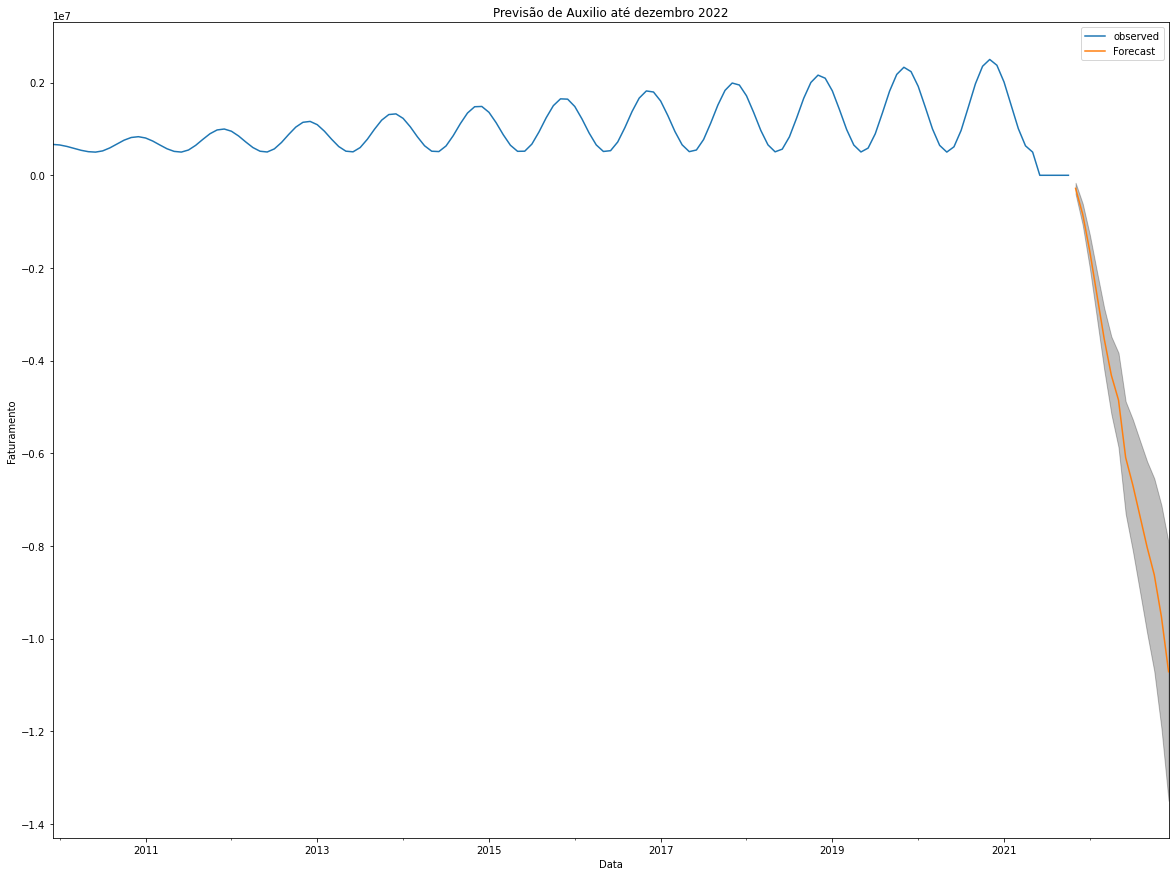

In [48]:
ax = df_aux.plot(label='observed', figsize=(20, 15))
plt.title('Previsão de Auxilio até dezembro 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')

plt.legend()
plt.show()

In [49]:
auxilio = pred_ci

### Bonificação

In [50]:
data = pd.DataFrame(columns=['order', 'seasonal_order', 'aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_bon,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            data = data.append(pd.DataFrame({'order': [param], 'seasonal_order': [param_seasonal], 'aic': results.aic}))
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue
data.sort_values('aic')

,order,seasonal_order,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",2327.13
0,"(0, 1, 1)","(1, 1, 1, 12)",2327.68
0,"(1, 1, 1)","(0, 1, 1, 12)",2328.89
0,"(0, 1, 1)","(0, 1, 1, 12)",2329.93
0,"(0, 0, 1)","(1, 1, 1, 12)",2346.56
...,...,...,...
0,"(1, 1, 0)","(0, 0, 0, 12)",2960.82
0,"(0, 1, 0)","(0, 0, 0, 12)",2997.87
0,"(1, 0, 0)","(0, 0, 0, 12)",3006.96
0,"(0, 0, 1)","(0, 0, 0, 12)",3029.35


In [51]:
# Vamos agora ajustar o modelo SARIMA com os parâmetros acima (dar fit no modelo):

mod = sm.tsa.statespace.SARIMAX(df_bon,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # modelo treinado

In [52]:
pred = results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=False) # valor previsto
pred_ci = pred.conf_int()

In [53]:
pred #valor previsto

In [54]:
pred_ci

,lower bonificacao,upper bonificacao
Data,,
2012-01-01,-3394.76,3394.76
2012-02-01,-102105.87,329140.83
2012-03-01,-100786.24,330489.36
2012-04-01,-98301.36,332994.99
2012-05-01,-102808.44,328502.80
...,...,...
2021-06-01,-161617.81,269593.79
2021-07-01,-103249.38,327962.19
2021-08-01,-123690.73,307520.82


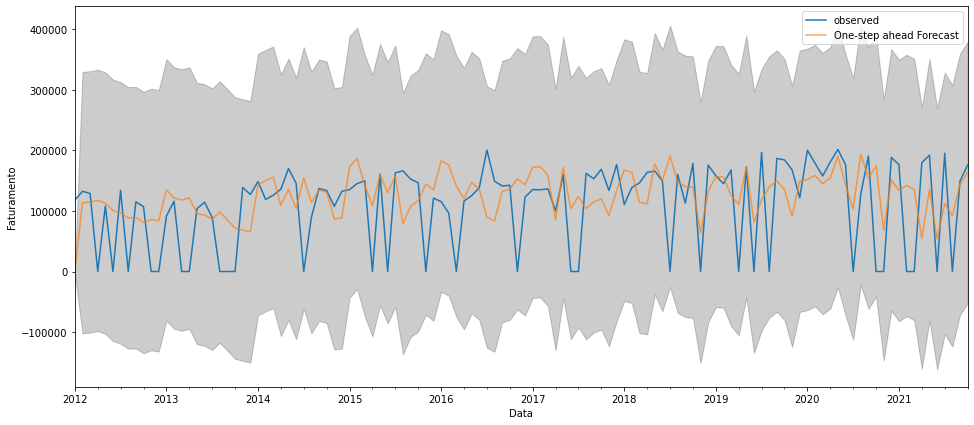

In [55]:
# Plot com o Forecasting

plt.figure(figsize=(16,7))

ax = df_bon.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')
plt.legend()

plt.show()

In [56]:
# Vamos fazer 14 predições futuras
pred_uc = results.get_forecast(steps=14)

# Define o intervalo de confiança para o Forecasting
pred_ci = pred_uc.conf_int()

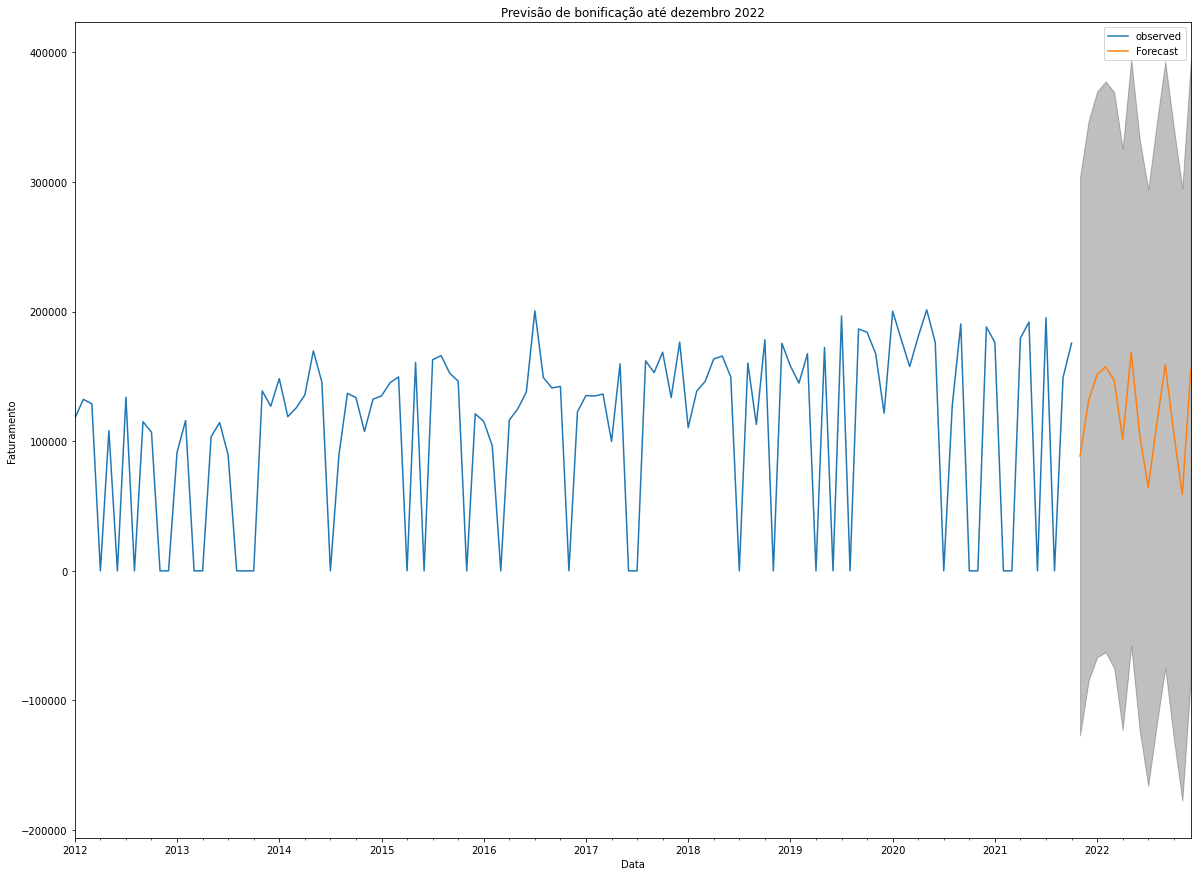

In [57]:
ax = df_bon.plot(label='observed', figsize=(20, 15))
plt.title('Previsão de bonificação até dezembro 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')

plt.legend()
plt.show()

In [58]:
bonificacao = pred_ci

### Saúde

In [59]:
data = pd.DataFrame(columns=['order', 'seasonal_order', 'aic'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_sau,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            data = data.append(pd.DataFrame({'order': [param], 'seasonal_order': [param_seasonal], 'aic': results.aic}))
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue
data.sort_values('aic')

,order,seasonal_order,aic
0,"(1, 1, 0)","(1, 1, 0, 12)",1019.47
0,"(1, 1, 1)","(1, 1, 0, 12)",1019.83
0,"(1, 0, 1)","(1, 1, 0, 12)",1035.64
0,"(1, 0, 0)","(1, 1, 0, 12)",1049.03
0,"(0, 1, 1)","(1, 1, 0, 12)",1049.48
...,...,...,...
0,"(0, 0, 0)","(0, 1, 1, 12)",3235.57
0,"(0, 0, 1)","(1, 1, 1, 12)",3238.13
0,"(1, 0, 0)","(0, 1, 1, 12)",3243.66
0,"(0, 0, 0)","(1, 1, 1, 12)",3257.60


In [60]:
# Vamos agora ajustar o modelo SARIMA com os parâmetros acima (dar fit no modelo):

mod = sm.tsa.statespace.SARIMAX(df_sau,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit() # modelo treinado

In [61]:
pred = results.get_prediction(start=pd.to_datetime('2016-12-01'), dynamic=False) # valor previsto
pred_ci = pred.conf_int()

In [62]:
pred #valor previsto

In [63]:
pred_ci

,lower saude,upper saude
Data,,
2016-12-01,-3394.76,3394.76
2017-01-01,2381124.14,7563228.96
2017-02-01,4570349.56,9752454.43
2017-03-01,6781276.43,11963381.30
2017-04-01,8086348.89,13268453.76
2017-05-01,9596007.66,14778112.54
2017-06-01,9957491.96,15139596.84
2017-07-01,10779372.26,15961477.14
2017-08-01,11885960.29,17068065.17


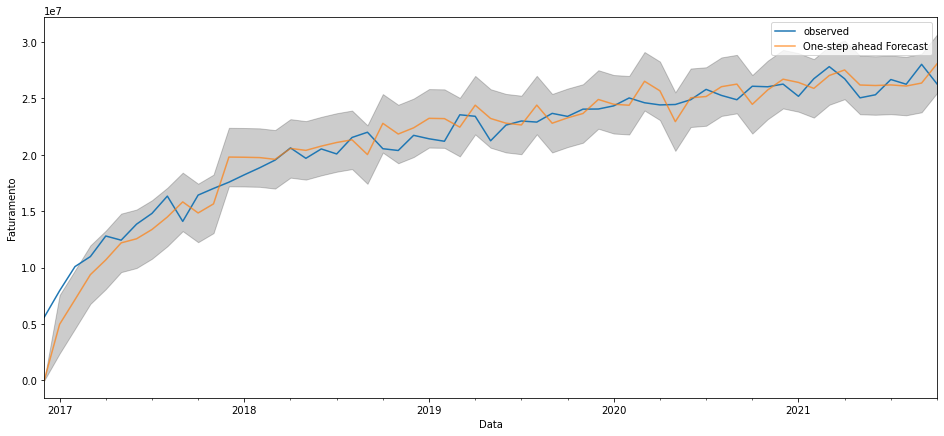

In [64]:
# Plot com o Forecasting

plt.figure(figsize=(16,7))

ax = df_sau.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')
plt.legend()

plt.show()

In [65]:
# Vamos fazer 14 predições futuras
pred_uc = results.get_forecast(steps=14)

# Define o intervalo de confiança para o Forecasting
pred_ci = pred_uc.conf_int()

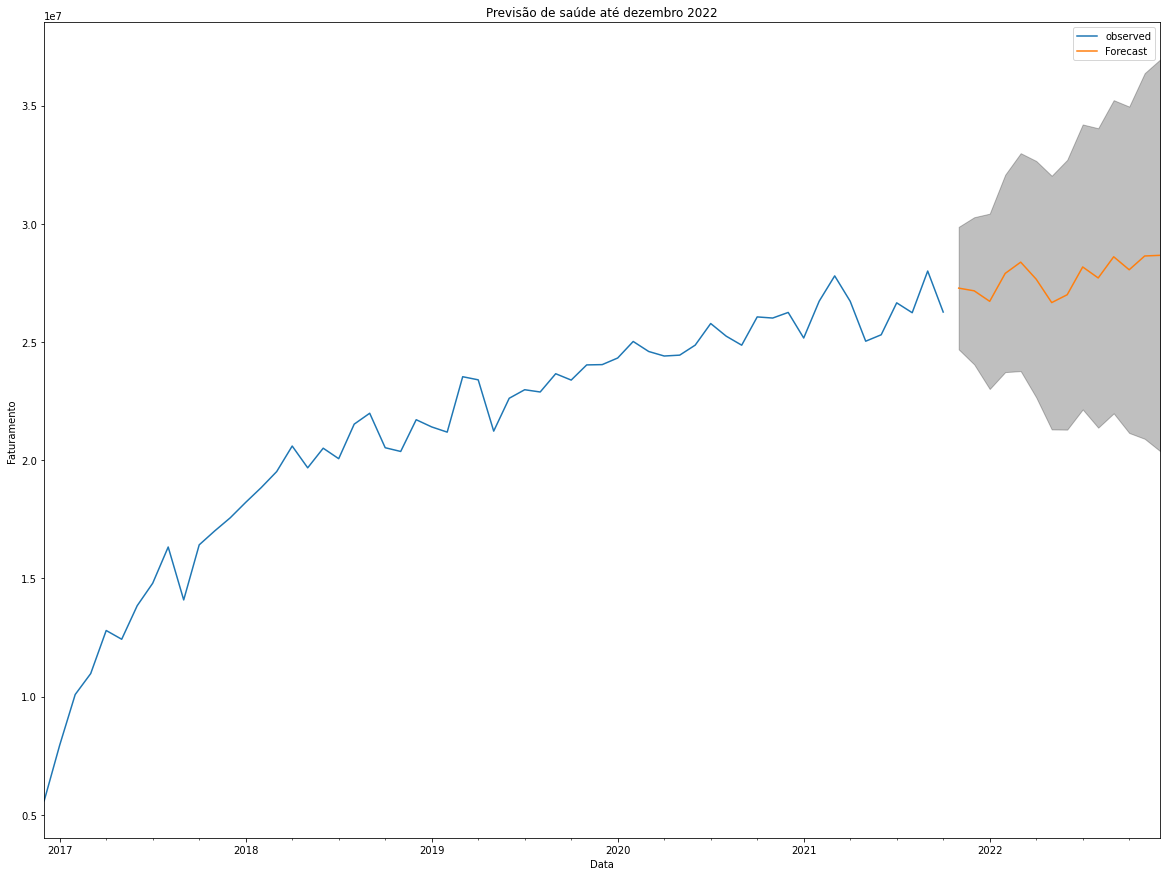

In [66]:
ax = df_sau.plot(label='observed', figsize=(20, 15))
plt.title('Previsão de saúde até dezembro 2022')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Faturamento')

plt.legend()
plt.show()

In [67]:
saude = pred_ci

### c. Qual dos dois cenários obteve a melhor projeção? Qual cenário você usaria dentro da sua empresa pensando nos desdobramentos estratégicos citados acima? Justifique a sua resposta com base em métricas bem definidas e no entendimento do problema.

In [68]:
alimenticio

,lower alimenticio,upper alimenticio
2021-11-01,2029784841.35,2032360202.61
2021-12-01,2078622554.18,2082264664.99
2022-01-01,2040798343.68,2045259000.22
2022-02-01,2041727278.14,2046878000.65
2022-03-01,2024938834.77,2030697517.61
2022-04-01,2049096570.01,2055404890.99
2022-05-01,2035402200.27,2042215965.68
2022-06-01,2016283221.08,2023567442.71
2022-07-01,1998912800.76,2006638884.52
2022-08-01,2027300092.11,2035444099.47


In [69]:
transporte

,lower transporte,upper transporte
2021-11-01,163073742.50,186834766.14
2021-12-01,156918279.61,193065361.96
2022-01-01,151148319.31,196410189.37
2022-02-01,143135423.62,195962142.23
2022-03-01,138077452.74,197513868.50
2022-04-01,116040478.91,181421767.03
2022-05-01,116470315.00,187299250.86
2022-06-01,114522617.10,190409134.17
2022-07-01,112732085.94,193359555.15
2022-08-01,111797508.27,196902232.63


In [70]:
auxilio

,lower auxilio_final_de_ano,upper auxilio_final_de_ano
2021-11-01,-401744.60,-162355.94
2021-12-01,-1076894.83,-613395.01
2022-01-01,-2011530.16,-1289911.21
2022-02-01,-3098853.58,-2087936.69
2022-03-01,-4193721.57,-2865476.23
2022-04-01,-5152067.80,-3481092.73
2022-05-01,-5869660.24,-3832714.80
2022-06-01,-7304032.85,-4879676.21
2022-07-01,-8100871.72,-5269188.14
2022-08-01,-8983777.53,-5726164.23


In [71]:
bonificacao

,lower bonificacao,upper bonificacao
2021-11-01,-127064.06,304147.45
2021-12-01,-84584.78,347126.79
2022-01-01,-66655.00,369711.39
2022-02-01,-62750.49,377600.55
2022-03-01,-75095.68,369266.36
2022-04-01,-122726.16,325604.58
2022-05-01,-57790.50,394474.78
2022-06-01,-123392.65,332773.17
2022-07-01,-165770.23,294263.09
2022-08-01,-118769.54,345099.04


In [72]:
saude

,lower saude,upper saude
2021-11-01,24686109.29,29868211.04
2021-12-01,24049323.54,30276286.40
2022-01-01,23010163.19,30427347.96
2022-02-01,23724678.14,32075656.36
2022-03-01,23767486.91,32984889.95
2022-04-01,22655166.77,32655929.64
2022-05-01,21300473.83,32030134.08
2022-06-01,21292371.30,32703654.71
2022-07-01,22145401.41,34200083.72
2022-08-01,21374857.09,34040214.33


### Resolução

Considerando que o auxilio final de ano não tinha faturamento desde maio de 2021 entendemos que o produto foi retirado do portifólio da organização, por isso o excluímos da projeção por produtos;

<AxesSubplot:>

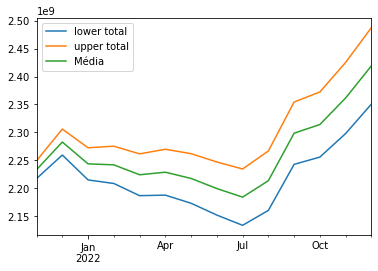

In [73]:
## Criando um DF para organizar em anos e produtos
df_projecao = pd.concat([alimenticio,transporte,bonificacao,saude], axis=1)
df_projecao['lower total'] = df_projecao['lower alimenticio'] + df_projecao['lower transporte'] + df_projecao['lower bonificacao'] + df_projecao['lower saude']
df_projecao['upper total'] = df_projecao['upper alimenticio'] + df_projecao['upper transporte'] + df_projecao['upper bonificacao'] + df_projecao['upper saude']
df_projecao['Média'] = (df_projecao['upper total'] + df_projecao['lower total'])/2

# df_projecao['lower total':'Média']

df_final = df_projecao[['lower total','upper total','Média']]
df_final.plot()

In [74]:
df_final.sum()

lower total   31040955336.16
upper total   32284335264.01
Média         31662645300.08
dtype: float64

In [75]:
faturamento_total['Média'] = (faturamento_total['lower faturamento']+faturamento_total['upper faturamento'])/2
faturamento_total.sum()

lower faturamento   29994480347.41
upper faturamento   33030526089.04
Média               31512503218.23
dtype: float64

In [76]:
faturamento_total

,lower faturamento,upper faturamento,Média
2021-11-01,2185532741.35,2264297192.36,2224914966.85
2021-12-01,2210025901.83,2324113178.80,2267069540.32
2022-01-01,2162245249.23,2303057091.01,2232651170.12
2022-02-01,2153481922.87,2316699700.11,2235090811.49
2022-03-01,2125401021.16,2308300203.32,2216850612.24
2022-04-01,2121983978.84,2322643339.09,2222313658.96
2022-05-01,2105122179.32,2322092792.26,2213607485.79
2022-06-01,2079647285.92,2311785854.24,2195716570.08
2022-07-01,2060865685.93,2307240162.94,2184052924.43
2022-08-01,2081171118.28,2341002700.17,2211086909.23


In [77]:
df_final['amplitude por produto'] = df_final['upper total'] - df_final['lower total']
df_final['amplitude geral'] = faturamento_total['upper faturamento'] - faturamento_total['lower faturamento']

In [78]:
df_final.sum()

lower total             31040955336.16
upper total             32284335264.01
Média                   31662645300.08
amplitude por produto    1243379927.85
amplitude geral          3036045741.63
dtype: float64

#### c. Qual dos dois cenários obteve a melhor projeção? Qual cenário você usaria dentro da sua empresa pensando nos desdobramentos estratégicos citados acima? Justifique a sua resposta com base em métricas bem definidas e no entendimento do problema.

Concluímos que a projeção feita por produtos teve melhor resultado pois a amplitude da projeção é menor, ou seja, acreditamos que o modelo por produto seja mais eficaz. 
Percebemos que a projeção por produto foi melhor, pois permite dar um tratamento específico para cada unidade de negócio, observamos que as vendas cessaram do produto **auxílio** por isso se fez necessário retirá-lo das projeções.

Por conta disso usaríamos o quebramento por produto, esse modelo nos permitiu trazer um melhor resultado.

In [79]:
df_fat

Data
2009-12-01   1006861314.02
2010-01-01    999352405.33
2010-02-01   1000041089.71
2010-03-01    990580597.41
2010-04-01    994746593.43
                  ...     
2021-06-01   2086224361.77
2021-07-01   2073233397.77
2021-08-01   2101590113.29
2021-09-01   2179517932.77
2021-10-01   2193339863.39
Freq: MS, Name: faturamento, Length: 143, dtype: float64